Author: 

In [306]:
# Some imports to get us started
import warnings
warnings.simplefilter('ignore')

# Utilities
import os
import urllib.request
import numpy as np
import pandas as pd
from networkx.drawing.nx_pydot import to_pydot
from IPython.display import Image, display

# Generic ML imports
import lightgbm as lgb
from sklearn.preprocessing import PolynomialFeatures

# DoWhy imports 
import dowhy
from dowhy import CausalModel
from dowhy import gcm


# EconML imports
from econml.iv.dr import LinearIntentToTreatDRIV
from econml.cate_interpreter import SingleTreeCateInterpreter, \
                                    SingleTreePolicyInterpreter

import matplotlib.pyplot as plt
%matplotlib inline

Loan is the main profit source for a bank with the profit mainly generated from the interest paid on the loan. Inorder to get this process profitable, the bank needs to know if the loan applicant will be able to pay back the loan along with the interest. Inorder to make this decision, in this article, we discuss the way in which the an appreciability factor of the property over the last 5 years (1 for yes, 0 for no) or a treatment affects the eligibility of the loan applicant. In doing so we will discuss about how different variables are involved to understand the causal relationship which helps us to find the conditional probability for different states of the variables in the network.

The task is for estimating the causal effect of property appreciability on finding the loan elligibility for the applicant who wants to buy a Property in one of the three different areas.

# Data Exploration and Preprocessing

Before starting with Causal Estimation, we need to explore the dataset and preprocess it for the task in hand. We are going to be using the loan eligibility dataset at https://github.com/mridulrb/Predict-loan-eligibility-using-IBM-Watson-Studio/tree/master/Dataset

For our purposes, we are going to use pandas for loading the csv files in the provided dataset. We are going to load train set to form one dataframe called "data". In this case, we are not using test file and will make data for testing from samples in train file since test file does not have the ground truth. We do this for preprocessing all the data together. Later for inference using BN, we are going to split this data into test and train dataframes.

In [307]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import numpy as np
import seaborn as sns
data=pd.read_csv("Loan_data.csv")

In [308]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


We can use the data.head() command to see the top few rows of the loaded dataframe. This gives us an idea about different variables involved. A quick look at "LoanAmount" shows that there are also missing values in the dataset labelled with Nan. This is normally the case and we first need to find out the missing values for each of the variables and then fill them up.

For this purpose, we are going to apply isnull function using the code given in the cell below, which finds the missing values for each variable in the dataset

In [309]:
data.apply(lambda x: sum(x.isnull()),axis=0)

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

We can see that some of the variables have missing values. Depending upon the type of variable, we are going to use mode for categorical variables for filling missing values and mean for filling numerical variables.

In [310]:
#categorical
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Dependents'].fillna(data['Dependents'].mode()[0], inplace=True)
data['Loan_Amount_Term'].fillna(data['Loan_Amount_Term'].mode()[0], inplace=True)
data['Credit_History'].fillna(data['Credit_History'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)
#numerical
data['LoanAmount'].fillna(data['LoanAmount'].mean(), inplace=True)

We begin by finding the columns which have categorical form and the following code snippet can be used to extract the columns that corresspond to categorical variables

In [311]:
drop_col = ['Loan_ID']
data = data.drop(columns=drop_col)

In [312]:
import numpy as np

struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

print(non_numeric_columns)

['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']


For this work, we are also going to convert the numerical variables into categories for implementation. For this data, we have the following variables currently corressponding to numerical variables:

LoanAmount

ApplicantIncome

Coapplicantincome

Loan_Amount_Term


First, for the sake of easy demonstration, we are going sum the ApplicantIncome and Coapplicantincome into one variable called TotalIncome and drop the variables ApplicantIncome and CoapplicantIncome from the overall data. The following code snippet can be used for this purpose.

In [313]:
struct_data['TotalIncome']= struct_data['ApplicantIncome'] +struct_data['CoapplicantIncome'] 
drop_col = ['ApplicantIncome','CoapplicantIncome']
struct_data = struct_data.drop(columns=drop_col)

Inorder to ultimately convert the numerical variables into catergorical, we first need to discretize the numerical variables. Inorder to box thse variables into discrete bins, we first need to decide the bin boundaries. For this purpose we are going to use boxplot and hitogram to visualize these variables

<AxesSubplot:ylabel='TotalIncome'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:ylabel='LoanAmount'>

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Loan_Amount_Term'>

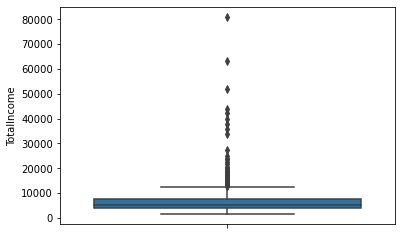

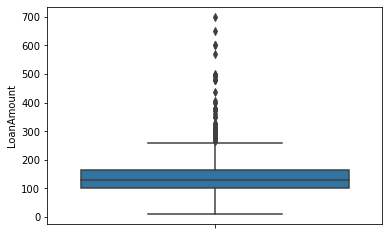

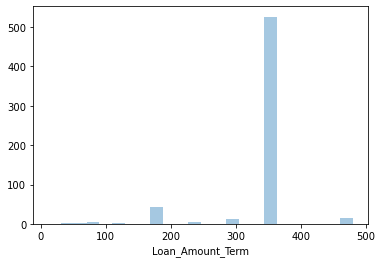

In [314]:
sns.boxplot(y='TotalIncome',data=struct_data)
plt.figure()
sns.boxplot(y='LoanAmount',data=data)
plt.figure()
sns.distplot(data.Loan_Amount_Term.dropna(),kde=False)
plt.show()




We can see from the above plots that the following boundaries can be used for the variables:

TotalIncome = [15000,50000]

LoanAmount = [200,550]

Loan_Amount_Term = [365]


Now that we have the boundaries, we need to convert the variables into descretized values

In [315]:
discretised_data = struct_data.copy()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
discretised_data[['TotalIncome','LoanAmount','Loan_Amount_Term']] = scaler.fit_transform(discretised_data[['TotalIncome','LoanAmount','Loan_Amount_Term']])
print(discretised_data.head)

<bound method NDFrame.head of      Gender Married Dependents     Education Self_Employed  LoanAmount  \
0      Male      No          0      Graduate            No    0.198860   
1      Male     Yes          1      Graduate            No    0.172214   
2      Male     Yes          0      Graduate           Yes    0.082489   
3      Male     Yes          0  Not Graduate            No    0.160637   
4      Male      No          0      Graduate            No    0.191027   
..      ...     ...        ...           ...           ...         ...   
609  Female      No          0      Graduate            No    0.089725   
610    Male     Yes         3+      Graduate            No    0.044863   
611    Male     Yes          1      Graduate            No    0.353111   
612    Male     Yes          2      Graduate            No    0.257598   
613  Female      No          0      Graduate           Yes    0.179450   

     Loan_Amount_Term  Credit_History Property_Area Loan_Status  TotalIncome  
0 

In [316]:
from sklearn.preprocessing import LabelEncoder
non_numeric_columns = list(discretised_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    discretised_data[col] = le.fit_transform(discretised_data[col])
discretised_data["Credit_History"] = discretised_data["Credit_History"].astype(int)


discretised_data.head(5)

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome
0,1,0,0,0,0,0.198860,0.74359,1,2,1,0.055394
1,1,1,1,0,0,0.172214,0.74359,1,0,0,0.058435
2,1,1,0,0,1,0.082489,0.74359,1,2,1,0.019583
3,1,1,0,1,0,0.160637,0.74359,1,2,1,0.043980
4,1,0,0,0,0,0.191027,0.74359,1,2,1,0.057292


Since DoWhy is based on Causal Inference, we need to make a sample treatment Appreciability: maps to 0 for low, 1 for high.
The Appreciability_func function has defined a treatment taking into account all relevant features, taking into account leftover income after loan repayment proportional to cost of maintainence of propert corresponding to Urban :2, semiurban:1, rural: 0

An Income Comb feature has also been used to make a binary encoding of education and employment.

In [317]:
discretised_data['Appreciability']=0
discretised_data['IncomeComb']=0
for i in range(discretised_data.shape[0]):
    if discretised_data.Education[i]==0:
        if discretised_data.Self_Employed[i]==0:
            discretised_data.IncomeComb[i]=1
        else:
            discretised_data.IncomeComb[i]=0
    else:
            discretised_data.IncomeComb[i]=1
            
def Appreciability_func(W): # treatment function definition (Sample)
    for i in range(W.shape[0]):
        if W['Property_Area'][i]==0:            
            W['Appreciability'][i]=((W['TotalIncome'][i] * W['Loan_Amount_Term'][i])/12 -W['LoanAmount'][i]*W['Dependents'][i])/(-1)
        else:
            W['Appreciability'][i]=((W['TotalIncome'][i] * W['Loan_Amount_Term'][i])/12 -W['LoanAmount'][i]*W['Dependents'][i])/W['Property_Area'][i]
    for i in range(W.shape[0]):
        if W['Appreciability'][i] >= W['Appreciability'].mean():
            W['Appreciability'][i]=0
        else:
            W['Appreciability'][i]=1        
            

Appreciability_func(discretised_data)

print(discretised_data.head)


<bound method NDFrame.head of      Gender  Married  Dependents  Education  Self_Employed  LoanAmount  \
0         1        0           0          0              0    0.198860   
1         1        1           1          0              0    0.172214   
2         1        1           0          0              1    0.082489   
3         1        1           0          1              0    0.160637   
4         1        0           0          0              0    0.191027   
..      ...      ...         ...        ...            ...         ...   
609       0        0           0          0              0    0.089725   
610       1        1           3          0              0    0.044863   
611       1        1           1          0              0    0.353111   
612       1        1           2          0              0    0.257598   
613       0        0           0          0              1    0.179450   

     Loan_Amount_Term  Credit_History  Property_Area  Loan_Status  \
0           

# Causal Estimation

Now that we have preprocessed the data, we can start to build models using the DoWhy library which we will install below.

In [140]:
pip install dowhy

Note: you may need to restart the kernel to use updated packages.


The DoWhy library is primarily based on finding out if there exists a causal effect between two variables: the treatment variable and the the outcome variable.

In this Jupyter notebook, we can estimate one variable by variable basis i.e Map the effect of Appreciability on Loan Status (Outcome) or we can train a simple linear regressor to give an output of all the variables we want to check for influence.

This library is primarily a library that can check for effects of various Appreciabilitys along with their marginal costs to determine the effectiveness of Appreciability.

A sample Appreciability is given here, which is Appreciability


Now we will create a graph of all the factors influencing our outcome variable here: the Loan_Status

In [318]:
import graphviz

The edges added here, show the assumptions made by the graph before evaluating the model and estabilishing relationships

digraph {
	LoanAmount [label=LoanAmount]
	Self_Employed [label=Self_Employed]
	Education [label=Education]
	Loan_Status [label=Loan_Status]
	Dependents [label=Dependents]
	Loan_Amount_Term [label=Loan_Amount_Term]
	Property_Area [label=Property_Area]
	Credit_History [label=Credit_History]
	TotalIncome [label=TotalIncome]
	Appreciability [label=Appreciability]
	IncomeComb -> TotalIncome
	Dependents -> Appreciability
	Credit_History -> Appreciability
	LoanAmount -> Appreciability
	TotalIncome -> Appreciability
	Education -> IncomeComb
	Property_Area -> Appreciability
	Self_Employed -> IncomeComb
	Loan_Amount_Term -> Appreciability
	Appreciability -> Loan_Status
}



'doctest-output/Digraph.gv.png'

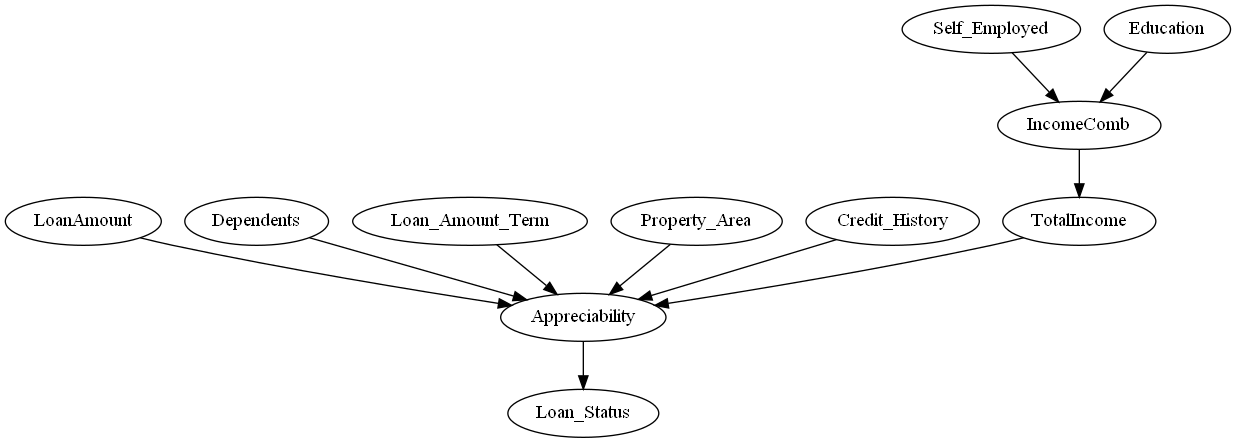

In [319]:
from IPython.display import Image, display

dot = graphviz.Digraph() 

dot.node('LoanAmount', 'LoanAmount')  
dot.node('Self_Employed', 'Self_Employed')
dot.node('Education', 'Education')
dot.node('Loan_Status', 'Loan_Status')
dot.node('Dependents','Dependents')
 
dot.node('Loan_Amount_Term','Loan_Amount_Term')
dot.node('Property_Area', 'Property_Area')
dot.node('Credit_History', 'Credit_History')
dot.node('TotalIncome', 'TotalIncome')
dot.node('Appreciability','Appreciability')

dot.edge('IncomeComb','TotalIncome')
dot.edge('Dependents','Appreciability')
dot.edge('Credit_History','Appreciability')
dot.edge('LoanAmount','Appreciability')
dot.edge('TotalIncome','Appreciability')
dot.edge('Education','IncomeComb')
dot.edge('Property_Area','Appreciability')
dot.edge('Self_Employed','IncomeComb')
dot.edge('Loan_Amount_Term','Appreciability')
dot.edge('Appreciability','Loan_Status')

print(dot.source)

dot.format = 'png'
dot.render(directory='doctest-output', view = True).replace('\\', '/')
display(Image(filename="Digraph.gv.png"))

We can see a basic digraph for the assumptions made in the Loan_Status feature.

We now divide the features into their relevant categories.

In [320]:
# Define estimator inputs
discretised_data2 = discretised_data[['TotalIncome','Credit_History','Property_Area','Loan_Amount_Term','Dependents','Education','Self_Employed','LoanAmount']]
test_data = discretised_data.iloc[:1000]
T = discretised_data["Appreciability"]  # multiple interventions, or Appreciabilitys
Y = discretised_data["Loan_Status"]  # amount of product purchased, or outcome

X= discretised_data2
Z = discretised_data['IncomeComb'] # nudge, or instrument



Now using EconML which is integrated with DoWhy we define the parameters for an XGBOOST classifier.

In [321]:
import lightgbm as lgb

# Define nuissance estimators
lgb_T_XZ_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}

lgb_Y_X_params = {
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'num_leaves' : 30,
    'max_depth' : 5
}
model_T_XZ = lgb.LGBMClassifier(**lgb_T_XZ_params)
model_Y_X = lgb.LGBMRegressor(**lgb_Y_X_params)
flexible_model_effect = lgb.LGBMRegressor(**lgb_Y_X_params)

Using EconML's Linear DRM estiamtor, we can check for the causal relationship between the treatment and the outcome.

In [326]:
est = LinearIntentToTreatDRIV(model_t_xwz=model_T_XZ, model_y_xw=model_Y_X,
                            flexible_model_effect=flexible_model_effect,
                            featurizer=PolynomialFeatures(degree=1, include_bias=False))

# fit through dowhy
test_data = X.iloc[:1000]
est_dw=est.dowhy.fit(Y, T,Z=Z, X=X, outcome_names=["Loan_Status"], treatment_names=["Appreciability"], 
                     feature_names=list(discretised_data2.columns.values), target_units=test_data,
                     inference="statsmodels")

Here we can see 2 causal relationships present between the treatment and outcome

In [327]:
identified_estimand = est_dw.identified_estimand_
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(E[Loan_Status|Credit_History,TotalIncome,Property_Area,Educa
d[Appreciability]                                                             

                                                           
tion,LoanAmount,Self_Employed,Loan_Amount_Term,Dependents])
                                                           
Estimand assumption 1, Unconfoundedness: If U→{Appreciability} and U→Loan_Status then P(Loan_Status|Appreciability,Credit_History,TotalIncome,Property_Area,Education,LoanAmount,Self_Employed,Loan_Amount_Term,Dependents,U) = P(Loan_Status|Appreciability,Credit_History,TotalIncome,Property_Area,Education,LoanAmount,Self_Employed,Loan_Amount_Term,Dependents)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                            -1⎤
 ⎢   

# Evaluating the Estimand

We will now see the effect of the treatment on each of the data rows given whether the treatment caused a postive relation to having a loan status of 1 or a negative relation to the loan status of 1.

The realized estimand also gies a relationship between the features, and the mean value of the estimate shows the effectiveness of the feature.

Mean causal effect value of 37.97... indicates that a unit change in appreciaiblity indicates a ~38 change in change from loan status from 0 to 1.

In [328]:
lineardml_estimate = est_dw.estimate_
print(lineardml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
─────────────────(E[Loan_Status|Credit_History,TotalIncome,Property_Area,Educa
d[Appreciability]                                                             

                                                           
tion,LoanAmount,Self_Employed,Loan_Amount_Term,Dependents])
                                                           
Estimand assumption 1, Unconfoundedness: If U→{Appreciability} and U→Loan_Status then P(Loan_Status|Appreciability,Credit_History,TotalIncome,Property_Area,Education,LoanAmount,Self_Employed,Loan_Amount_Term,Dependents,U) = P(Loan_Status|Appreciability,Credit_History,TotalIncome,Property_Area,Education,LoanAmount,Self_Employed,Loan_Amount_Term,Dependents)

## Realized estimand
b: Loan_Status~Appreciability+Credit_History+TotalIncome+P

Using EconML's Singletreecateinterpreter, we can see the effect of the treatment on Loan_Amount_Term and Property_Area with the help of a simple binary tree.

The redder a box the more negative an effect, while the greener a box the more positive effect a treatment had towards achieving a loan status of 1.

The green boxes can be interpreted as people with less education and lesser loan amounts benefit the most from appreciable property in getting a favourable loan decision.

The red boxes imply that people with high education and high credit historyu tend to benefit least from having an appreciable property.

The max depth can be increased to get further detail.

<Figure size 2160x576 with 0 Axes>

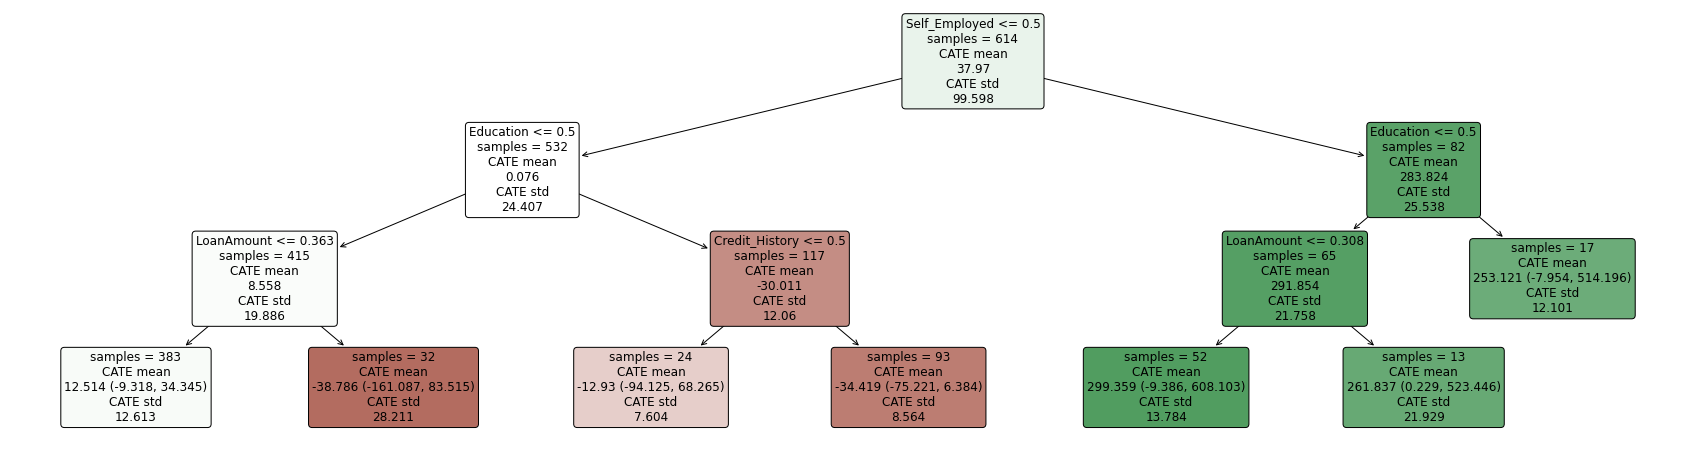

In [329]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=3, min_samples_leaf=10)
intrp.interpret(est_dw, test_data)
plt.figure(figsize=(30, 8))
intrp.plot(feature_names=X.columns, fontsize=12)

Then using the policy interpreter, we can check for the improvements made over the treatment policy and the recommended treatment.

CATE or condiitonal average treatment effect determines the change in each criteria and recommends whether appreciability is recommended  T(1) or not recommended T(0) over various risk levels.

<Figure size 2160x576 with 0 Axes>

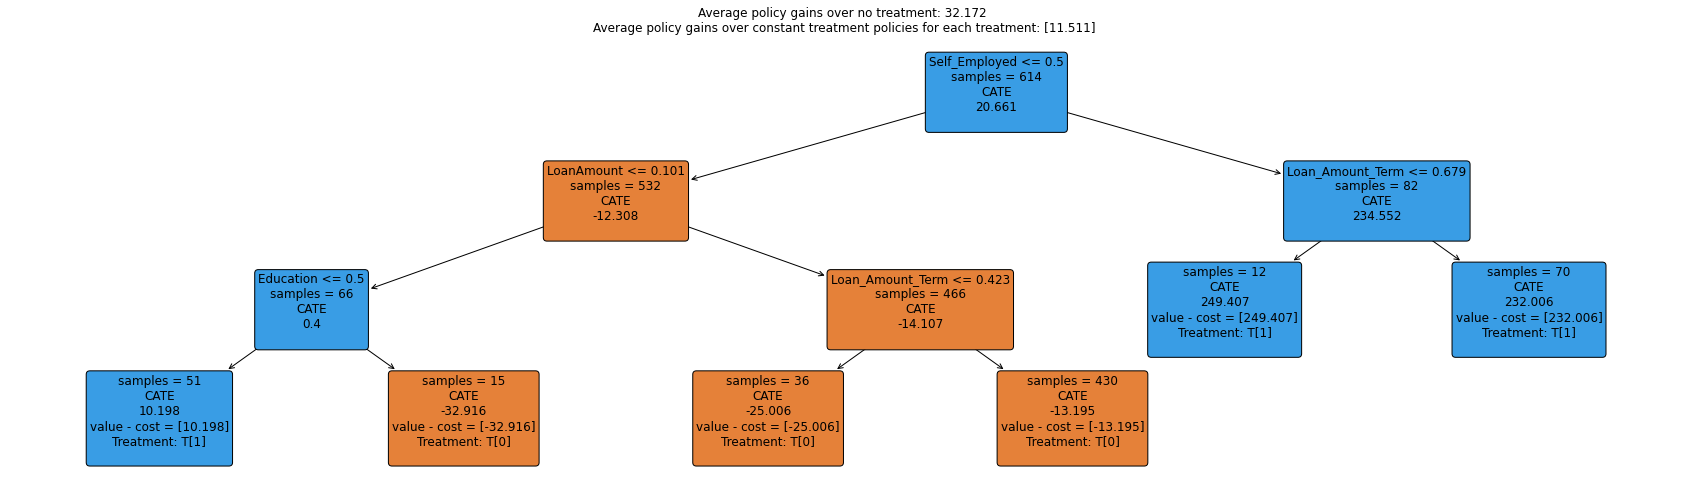

In [334]:
intrp = SingleTreePolicyInterpreter(risk_level=0.75, max_depth=3, min_samples_leaf=10)
intrp.interpret(est_dw, test_data, sample_treatment_costs=0.2)
plt.figure(figsize=(30, 8))
intrp.plot(feature_names=X.columns, fontsize=12)

We can also get a summary of the causal effect model

In [335]:
est_dw.summary(feature_names=X.columns)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
TotalIncome,-105.971,175.897,-0.602,0.547,-450.723,238.781
Credit_History,-21.727,32.604,-0.666,0.505,-85.63,42.175
Property_Area,3.608,30.725,0.117,0.907,-56.612,63.828
Loan_Amount_Term,-14.633,72.131,-0.203,0.839,-156.006,126.741
Dependents,-4.198,16.555,-0.254,0.8,-36.645,28.249
Education,-46.338,31.317,-1.48,0.139,-107.718,15.041
Self_Employed,289.887,153.852,1.884,0.06,-11.658,591.431
LoanAmount,-76.183,200.94,-0.379,0.705,-470.018,317.652
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,60.245,62.986,0.956,0.339,-63.205,183.695


#  Checking Performance

We can also check for robustness of the causal effect. Check for p-value close to 1.

In [352]:
res_random = est_dw.refute_estimate(method_name="random_common_cause", num_simulations=10)
print(res_random)

Refute: Add a random common cause
Estimated effect:37.970421256885594
New effect:-2.05053919903608
p value:9.066518350531183e-07



In [339]:
res_placebo = est_dw.refute_estimate(method_name="placebo_treatment_refuter", placebo_type="permute", 
                                     num_simulations=2)
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:37.970421256885594
New effect:-8.06426808815507
p value:0.24186009266110964



Placebo treatment <0.05: determines that the treatment has a non effect on the dataset.

# Predictions and Counterfactual Estimations

For estimating counterfactual scenarios. ie if Y=5 gives X output as 3, then what value of Y gives X output as 1.

The gcm part of DoWhy serves to do this.

In [153]:
import networkx as nx, numpy as np, pandas as pd
from dowhy import gcm



Processing data to give a training data set and a testing data set

In [236]:

data2 = struct_data[['LoanAmount','Loan_Amount_Term','Credit_History','Property_Area','Loan_Status','TotalIncome'
                     ,'Dependents','Education','Self_Employed']]
from sklearn.preprocessing import LabelEncoder
non_numeric_columns = list(data2.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    data2[col] = le.fit_transform(discretised_data[col])
data2["Credit_History"] = data2["Credit_History"].astype(int)

training_data = data2.sample(frac=0.75)
test_data = data2.drop(training_data.index)

print(training_data,test_data)

     LoanAmount  Loan_Amount_Term  Credit_History  Property_Area  Loan_Status  \
390       185.0             360.0               1              0            1   
583        61.0             360.0               1              0            0   
585       172.0              84.0               1              0            0   
521        55.0             360.0               1              1            1   
395       135.0             360.0               1              1            1   
..          ...               ...             ...            ...          ...   
226       138.0             360.0               1              2            0   
268       135.0             360.0               1              0            0   
363        95.0             300.0               1              2            1   
295       110.0             360.0               1              2            1   
317        88.0             360.0               1              2            1   

     TotalIncome  Dependent

We can create a causal graph using netwrok nx's Digraph for out structural causaL model to make assumptions. We can visualise this graph as well.

DoWhy is focused on structural causal model that use functional models for root nodes in graphs instead of conditional stochastic models.

We can input this graph into the model and auto assign causal mechanisms like empirical distributions and bayesian mixes to it.

An invertible structural causal model is used since we dont have noise data but have observed data instead.


{'Credit_History': Text(1.0, 1.9868214793548218e-08, 'Credit_History'),
 'Loan_Status': Text(0.7660444394347109, 0.6427875913329416, 'Loan_Status'),
 'Property_Area': Text(0.17364822875361818, 0.9848077430671602, 'Property_Area'),
 'LoanAmount': Text(-0.5000000496705369, 0.8660254023735695, 'LoanAmount'),
 'TotalIncome': Text(-0.9396926036166309, 0.34202023120707775, 'TotalIncome'),
 'Loan_Amount_Term': Text(-0.9396926036166309, -0.34202013186600383, 'Loan_Amount_Term'),
 'Self_Employed': Text(-0.49999990065892597, -0.8660254222417842, 'Self_Employed'),
 'Education': Text(0.1736481691489738, -0.9848077033307305, 'Education'),
 'Dependents': Text(0.7660443202254221, -0.6427877304104451, 'Dependents')}

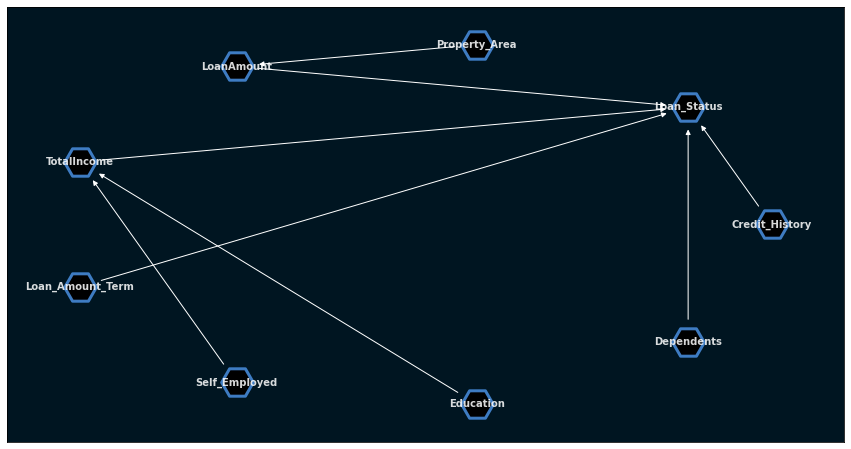

In [242]:
causal_graph = nx.DiGraph([('Credit_History', 'Loan_Status'), ('Property_Area', 'LoanAmount'),('LoanAmount','Loan_Status'),
                           ('TotalIncome','Loan_Status'),('Loan_Amount_Term','Loan_Status'),('Self_Employed','TotalIncome')
                          ,('Education','TotalIncome'), ('Dependents','Loan_Status')])

fig = plt.figure(figsize=(15, 8))  # set figsize
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor("#001521")  # set backgrount

pos = nx.drawing.layout.circular_layout(causal_graph)

nx.draw_networkx_nodes(
    causal_graph,
    pos,
    node_shape="H",
    node_size=1000,
    linewidths=3,
    edgecolors="#4a90e2d9",
    node_color=["black"],
)
# add labels
nx.draw_networkx_labels(
    causal_graph,
    pos,
    font_color="#FFFFFFD9",
    font_weight="bold",
    font_family="Helvetica",
    font_size=10,
)
# add edges
nx.draw_networkx_edges(
    causal_graph,
    pos,
    edge_color="white",
    node_shape="H",
    node_size=2000,
    
    width=[1],
)


Now we can fit the model

In [246]:

causal_model = gcm.InvertibleStructuralCausalModel(causal_graph) 
gcm.auto.assign_causal_mechanisms(causal_model, training_data)
gcm.fit(causal_model, training_data)

Fitting causal mechanism of node Dependents: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 694.29it/s]


Now we can generate various counterfactual models wherein we give observed data being the test_data and fix certain features and alter others in the test_data set and find out the effects.

In the example given below we see how changing Credit_History,TotalIncome,Dependents,Loan_Amount_Ternm and Self_Employed change the outcome of a Loan_Status.

We can change the values of our desired features to the value that we want while keeping the other features untouched using the same lambda expression.

In [303]:
pred=gcm.counterfactual_samples(
    causal_model,
    {'Credit_History': lambda x: 1,'Property_Area':lambda x:0, 'Loan_Amount_Term': lambda x : 12,'Education':lambda x:x,
    'Self_Employed':lambda x :1,'Dependents':lambda x : 0,'LoanAmount':lambda x : x,'TotalIncome':lambda x : 1000},
    observed_data=test_data)
print(pred)

     Dependents  Education  Self_Employed  TotalIncome  Loan_Amount_Term  \
0             0          0              1         1000                12   
1             0          0              1         1000                12   
2             0          0              1         1000                12   
3             0          1              1         1000                12   
4             0          0              1         1000                12   
..          ...        ...            ...          ...               ...   
149           0          0              1         1000                12   
150           0          0              1         1000                12   
151           0          1              1         1000                12   
152           0          0              1         1000                12   
153           0          0              1         1000                12   

     Property_Area  LoanAmount  Credit_History  Loan_Status  
0                0   79.4

Data processing for our of bounds values

In [304]:
for i in range(pred.shape[0]):
    if(pred['Loan_Status'][i]>1):
        pred['Loan_Status'][i]=1
    if(pred['Loan_Status'][i]<0):
        pred['Loan_Status'][i]=0
print(pred)

     Dependents  Education  Self_Employed  TotalIncome  Loan_Amount_Term  \
0             0          0              1         1000                12   
1             0          0              1         1000                12   
2             0          0              1         1000                12   
3             0          1              1         1000                12   
4             0          0              1         1000                12   
..          ...        ...            ...          ...               ...   
149           0          0              1         1000                12   
150           0          0              1         1000                12   
151           0          1              1         1000                12   
152           0          0              1         1000                12   
153           0          0              1         1000                12   

     Property_Area  LoanAmount  Credit_History  Loan_Status  
0                0   79.4

We can see the new predicted values for Loan_Status given here using our estimator.

In [305]:
net_change=pred['Loan_Status'].mean()-test_data['Loan_Status'].mean()
print(net_change," is the net change over these changes made to the test data")

0.11187951962383946  is the net change over these changes made to the test data


We can see that our changes have had a 0.111 better chance of recieving a loan per applicant.